In [1]:
# Import required packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from math import ceil
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from multiprocessing import Pool

In [2]:
# if tensorflow is not installed, run 'pip install tensorflow'
# pip install tensorflow

In [6]:
train_dir = './chest_xray/train/' # image folder

In [7]:
# get the list of jpegs from sub image class folders
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/NORMAL') if fn.endswith('.jpeg')]
pneumo_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg')]

In [6]:
# randomly select 3 of each
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)

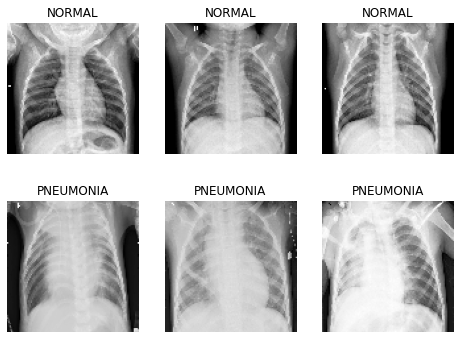

In [6]:
# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        fp = f'{train_dir}/PNEUMONIA/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')

In [7]:
plt.show()

In [10]:
# also check the number of files here
print(f"There are {len(normal_imgs)} normal images, and {len(pneumo_imgs)} pneumonia images")

There are 1341 normal images, and 3875 pneumonia images


In [28]:
imgs_pictures_normal = {'Label': 'Normal Image', 'Picture': normal_imgs}
imgs_pictures_normal_dataframe = pd.DataFrame(imgs_pictures_normal)
imgs_pictures_pneumo = {'Label': 'Pneumo Image', 'Picture': pneumo_imgs}
imgs_pictures_pneumo_dataframe = pd.DataFrame(imgs_pictures_pneumo)

In [30]:
imgs_df = pd.concat([imgs_pictures_normal_dataframe, imgs_pictures_pneumo_dataframe])

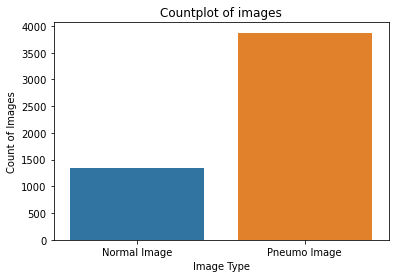

In [41]:
sns.countplot(x = 'Label', data = imgs_df).set(title = 'Countplot of images',
                                              xlabel = 'Image Type',
                                              ylabel = 'Count of Images')
plt.show()

In [4]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [8]:
# run it on our folders
normal_images = img2np(f'{train_dir}/NORMAL/', normal_imgs)
pnemonia_images = img2np(f'{train_dir}/PNEUMONIA/', pneumo_imgs)

In [10]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

In [9]:
norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pnemonia_images, 'PNEUMONIA')

NameError: name 'find_mean_img' is not defined

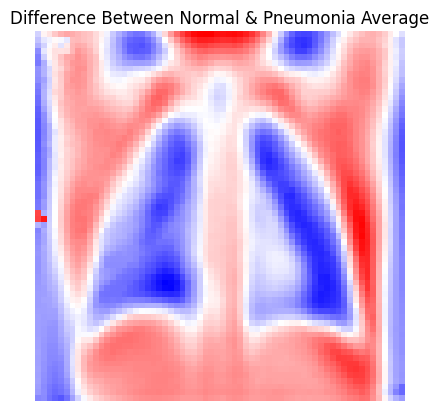

In [12]:
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()

Number of PC:  28


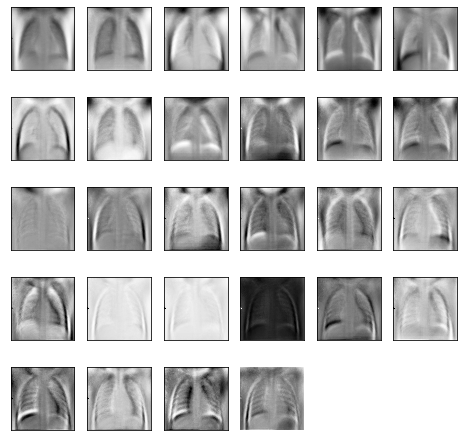

Number of PC:  14


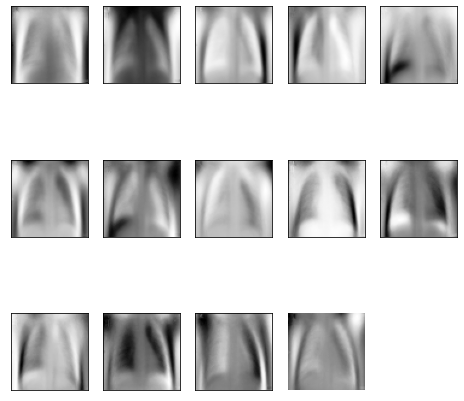

In [11]:
def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(normal_images, 'NORMAL'))
plot_pca(eigenimages(pnemonia_images, 'PNEUMONIA'))

In [35]:
def eigenimages_full(full_mat, title, n_comp = 10, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
pca_comp_normal = eigenimages_full(normal_images, 'NORMAL')
pca_comp_pneu = eigenimages_full(pnemonia_images, 'PNEUMONIA')

# Get the cumulative values

Number of PC:  10
Number of PC:  10


In [36]:
# Get the cumulative variance for both training datasets
var_cumu_pca_comp_normal = np.cumsum(pca_comp_normal.explained_variance_ratio_)
var_cumu_pca_comp_pneu = np.cumsum(pca_comp_pneu.explained_variance_ratio_)

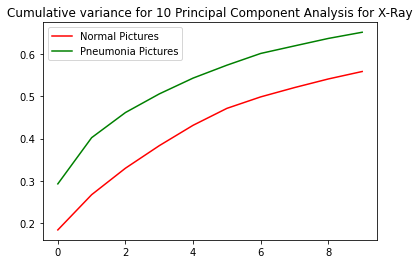

In [44]:
plt.plot(var_cumu_pca_comp_normal, 'red', label = 'Normal Pictures')
plt.plot(var_cumu_pca_comp_pneu, 'green', label = 'Pneumonia Pictures')
plt.title('Cumulative variance for 10 Principal Component Analysis for X-Ray')
plt.legend(loc = 'upper left')
plt.show()

Number of PC:  28
Number of PC:  14


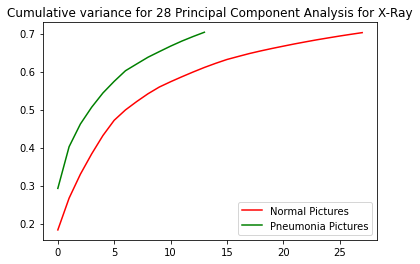

In [47]:
# Repeat the same process for the original  28 Principal Components
pca_comp_normal_28 = eigenimages(normal_images, 'NORMAL')
pca_comp_pneu_28 = eigenimages(pnemonia_images, 'PNEUMONIA')

# Store the cumulative frequencies again
var_cumu_pca_comp_normal_28 = np.cumsum(pca_comp_normal_28.explained_variance_ratio_)
var_cumu_pca_comp_pneu_28 = np.cumsum(pca_comp_pneu_28.explained_variance_ratio_)

# Plot it
plt.plot(var_cumu_pca_comp_normal_28, 'red', label = 'Normal Pictures')
plt.plot(var_cumu_pca_comp_pneu_28, 'green', label = 'Pneumonia Pictures')
plt.title('Cumulative variance for 28 Principal Component Analysis for X-Ray')
plt.legend(loc = 'lower right')
plt.show()

In [54]:
# Find standard deviation on pixels
def find_std_img(full_mat, title, size = (64, 64)):
    # Calculate the standard deviation
    std_img = np.std(full_mat, axis = 0)
    # Reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

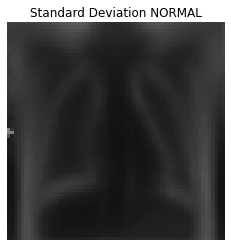

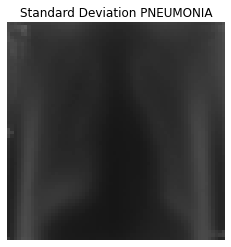

In [55]:
norm_std = find_std_img(normal_images, 'NORMAL')
pneu_std = find_std_img(pnemonia_images, 'PNEUMONIA')

In [2]:
# Define main functions for further EDA
def get_image_properties(impath):
    label = impath.split('/')[-2]
    if len(impath.split('.')[0].split('/')[-1].split('-',1)) < 2:
        imgno = impath.split('.')[0].split('/')[-1].split('_',1)[1]
    else:
        imgno = impath.split('.')[0].split('/')[-1].split('-',1)[1]
    
    im = imageio.imread(impath)
    br_med = np.median(im)
    br_std = np.std(im)
    xsize = im.shape[1]
    ysize = im.shape[0]
    datasplit = impath.split('/')[-3]
    return datasplit, impath, label, xsize, ysize, br_med, br_std, imgno



def get_image_properties_all(location_dataset_relative):  
    location_dataset=os.path.abspath(location_dataset_relative)
    dir_list = os.listdir(location_dataset)
    dir_list=[item for item in dir_list if '.' not in item]
    # print(dir_list)
    list_of_chest_categories=[]
    for folder in dir_list:
        # print("folder",folder)
        location_dataset_final=location_dataset + "/" + folder + "/"
        # print("location_dataset_final",location_dataset_final)
        list_of_chest_category = [os.path.join(location_dataset_final, file) for file in os.listdir(location_dataset_final)]
        list_of_chest_categories.append(list_of_chest_category)
    
    list_of_chest_categories= list(itertools.chain(*list_of_chest_categories))
    list_of_chest_categories = [item for item in list_of_chest_categories if '.' not in item]
    # print(list_of_chest_categories)
    image_paths=[]
    for directory in list_of_chest_categories:
        image_path = tf.io.gfile.glob([directory + '/*.jpeg', ])
        image_paths.append(image_path)
    
    image_paths= list(itertools.chain(*image_paths))
        
    with Pool(4) as p:
        image_props = list(tqdm(p.imap(get_image_properties, image_paths), total=100))


        df = pd.DataFrame(columns=['datasplit', 'path', 'label', 'xsize', 'ysize','br_med', 'br_std', 'imgno'])

        df['datasplit'] = np.array(image_props).T[0]
        df['path'] = np.array(image_props).T[1]
        df['label'] = np.array(image_props).T[2]
        df['xsize'] = np.array(image_props).T[3].astype(int)
        df['ysize'] = np.array(image_props).T[4].astype(int)
        df['br_med'] = np.array(image_props).T[5].astype(float)
        df['br_std'] = np.array(image_props).T[6].astype(float)
        df['imgno'] = np.array(image_props).T[7]
        
        df.to_csv('train_image_props.csv', index=False)
        return df
    # return

def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5, globalhist=False):
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df,
        height=8
    )
    g.set_axis_labels('X Size', 'Y Size')
    
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
            kde=False
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True,
            kde=False
        )
    # Do also global Hist:
    if globalhist:
        sns.distplot(
            df[col_x].values,
            ax=g.ax_marg_x,
            color='grey'
        )
        sns.distplot(
            df[col_y].values.ravel(),
            ax=g.ax_marg_y,
            color='grey',
            vertical=True
        )
    plt.legend(legends)
    plt.show()
    # plt.savefig('distribution.png')


def chart_data(df_image_properties):
    data_stats = df_image_properties.groupby(['datasplit'])['label'].value_counts().reset_index(name='counts')

    chart = alt.Chart(data_stats).mark_bar().encode(
        x=alt.X('label:N', axis=alt.Axis(format='', title='')),
        y=alt.X('counts:Q', axis=alt.Axis(title='Counts', grid=False)),
        color=alt.Color('label:N', legend=alt.Legend(title="Labels by color")),
        column=alt.Column('datasplit:N', header=alt.Header(title=[''], labelOrient='bottom')),
        tooltip=['counts:Q', 'label:N']
    ).properties(
    width=200,
    height=200
    )

    chart.configure_title(
        fontSize=20,
        font='Courier',
        anchor='start',
        color='black',
        align='center',
    ).configure_view(
    strokeWidth=0
    )
    chart.save("chart.html")

def plot_brightness(df_image_properties):
    df_image_properties.br_med.hist()
    plt.xlabel('Median Brigthness')
    plt.ylabel('Counts')
    plt.show()

In [ ]:
location_dataset_relative='../src/chest_xray/'
df_image_properties = get_image_properties_all(location_dataset_relative)
df_image_properties.style.set_caption('Head Image Properties')
multivariateGrid('xsize', 'ysize', 'datasplit', df=df_image_properties)
chart_data(df_image_properties)
plot_brightness(df_image_properties)

  0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
# Coronary disease EDA
#investigate a single image from positive dataset
pos_path = '/dataset/train/POSITIVE/'
def load_image(path):
    for img in os.listdir(pos_path):
        print('Image name =', img)
        image = cv.imread(os.path.join(pos_path, img))
        break

    return image

In [3]:
image = load_image(pos_path)
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Positive Coronary CT Angiography')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.4f}")
print(f"The minimum pixel value is {image.min():.4f}")
print(f"The mean value of the pixels is {image.mean():.4f}")
print(f"The standard deviation is {image.std():.4f}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/dataset/train/POSITIVE/'